In [1]:
import os
import re
from collections import Counter
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cm = 1/2.54

# force GPU device
os.environ["CUDA_VISIBLE_DEVICES"]='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from keras import Sequential, Input
from keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy
from keras.optimizers import Adam
from keras.models import load_model
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from utils import *

In [2]:
max_sequence_length = 100
experiment_name = 'feature_user_size'
top_k = 3

In [3]:
checkpoint_path = f'saves/{experiment_name}'
model_path = f'{checkpoint_path}/model.keras'
log_path = f'{checkpoint_path}/log.csv'
history_path = f'{checkpoint_path}/history.npy'

# ensure directory exists
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [4]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences_export_benign_filetypes_more/'
unusable_threshold = 10
rare_threshold = 50
splits = (0.7, 0.15, 0.15)

max_sequence_length = 100

assert(sum(splits) == 1)

print(f'experiment parameters: \n{data_directory=} \n{unusable_threshold=} \n{rare_threshold=} \n{splits=} \n{max_sequence_length=}')

experiment parameters: 
data_directory='/home/jrosendahl/datasets/cadets/sequences_export_benign_filetypes_more/' 
unusable_threshold=10 
rare_threshold=50 
splits=(0.7, 0.15, 0.15) 
max_sequence_length=100


In [5]:
total_classes = 0

# unusable classes will be removed from the dataset
unusable_classes = []
# rare classes will be oversampled
rare_classes = []

# all classes in training data (all classes - unusable classes)
classes = []

# walk all files, build unusable_classes, rare_classes
classes_occurrences = Counter()
for filename in os.listdir(data_directory):
    label = class_from_filename(filename)
    classes_occurrences[label] += 1

total_classes = len(classes_occurrences)
for label, count in classes_occurrences.items():
    if count < unusable_threshold:
        unusable_classes.append(label)
    elif count < rare_threshold:
        rare_classes.append(label)
        classes.append(label)
    else:
        classes.append(label)

print(f'Total classes: {total_classes}')
print(f'Unusable classes: {len(unusable_classes)}')
print(f'\t{unusable_classes}')
print(f'Rare classes: {len(rare_classes)}')
print(f'\t{rare_classes}')

labels_cardinality = len(set(classes))
print(f'Usable classes: {labels_cardinality}')

Total classes: 118
Unusable classes: 51
	['ping', 'pwd_mkdb', 'vi', 'tr', 'uname', 'msgs', 'screen', 'pw', 'bzip2', 'bzcat', 'nginx', 'stat', 'tail', 'smtp', 'kenv', 'nawk', 'ssh', 'chown', 'cut', 'php-fpm', 'jot', 'xz', 'diff', 'bounce', 'links', 'ipfw', 'touch', 'env', 'pfctl', 'minions', 'csh', 'kldstat', 'su', 'nohup', 'stty', 'df', 'limits', 'id', 'postmap', 'ifconfig', 'chkgrp', 'ipfstat', 'locale', 'devd', 'uniq', 'XIM', 'getty', 'which', 'init', 'test', 'nice']
Rare classes: 20
	['wc', 'grep', 'mktemp', 'less', 'tty', 'mailwrapper', 'kill', 'lockf', 'mount', 'tee', 'expr', 'ps', 'route', 'sed', 'cmp', 'egrep', 'sort', 'basename', 'awk', 'mail']
Usable classes: 67


In [6]:
# split into train, validation, test
labels_set = set()

filenames_all = []

filenames_train = []
filenames_val = []
filenames_test = []

for filename in os.listdir(data_directory):
    label = class_from_filename(filename)
    if label in unusable_classes:
        continue
    labels_set.add(label)
    filenames_all.append(filename)

# stratisfied split
test_vs_val = splits[2] / (splits[1] + splits[2])
filenames_train, filenames_val_test = train_test_split(filenames_all, test_size=splits[1]+splits[2], stratify=[class_from_filename(f) for f in filenames_all])
filenames_val, filenames_test = train_test_split(filenames_val_test, test_size=test_vs_val, stratify=[class_from_filename(f) for f in filenames_val_test])

print(f'Train: {len(filenames_train)}')
print(f'Validation: {len(filenames_val)}')
print(f'Test: {len(filenames_test)}')

# build labels_map in alphabetical order
labels_map = {}
for i, label in enumerate(sorted(labels_set)):
    labels_map[label] = i

Train: 150475
Validation: 32245
Test: 32245


In [7]:
# load data
count_files_read = 0
count_sequences_split = 0
count_splits = 0

preprocessor = Preprocessor(['TYPE', 'USERNAME'])

def parse_file(filename) -> tuple[list[int], list[list[int]]]:
    """
    Parse a file and return the vectorized data. Not a pure function (calls parse_line)!
    """
    global count_files_read, count_sequences_split, count_splits

    y_list: list[int] = []
    X_list: list[list[int]] = []
    y = class_from_filename(filename)
    y = labels_map[y]
    with open(os.path.join(data_directory, filename), 'r') as f:
        lines = f.readlines()
        count_files_read += 1
    if count_files_read % 50000 == 0:
        print(f'Files read: {count_files_read}')
    X = []
    for line in lines:
        line_res = preprocessor.process(line)
        event = line_res['TYPE']
        username = line_res['USERNAME']
        X.append((event, username))

    # check if sequence needs to be split
    if len(X) > max_sequence_length:
        count_sequences_split += 1
        count_splits += len(X) // max_sequence_length
        for i in range(0, len(X), max_sequence_length):
            y_list.append(y)
            X_list.append(X[i:i+max_sequence_length])
        assert len(X_list[0]) == max_sequence_length
    else:
        y_list.append(y)
        X_list.append(X)

    # transform elements to numpy arrays
    y_list = np.array(y_list)
    X_list = [np.array(x) for x in X_list]

    assert len(y_list) == len(X_list)
    return y_list, X_list


y_train = []
X_train = []
y_val = []
X_val = []
y_test = []
X_test = []

for filename in filenames_train:
    try:
        y_list, X_list = parse_file(filename)
    except Exception as e:
        print(f'Error parsing file: {filename}')
        raise e
    y_train.extend(y_list)
    X_train.extend(X_list)

for filename in filenames_val:
    y_list, X_list = parse_file(filename)
    y_val.extend(y_list)
    X_val.extend(X_list)

for filename in filenames_test:
    y_list, X_list = parse_file(filename)
    y_test.extend(y_list)
    X_test.extend(X_list)

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)
assert len(X_test) == len(y_test)

print(f'Files read: {count_files_read}')
print(f'Sequences split: {count_sequences_split}')
print(f'Splits: {count_splits}')


event_types_map = preprocessor.event_types_map
users_map = preprocessor.users_map

event_types_cardinality = len(event_types_map)
username_cardinality = len(users_map)

print(f'Event types: {event_types_cardinality}')
print(f'Usernames: {username_cardinality}')

# print lengths
print(f'Train: {len(y_train)}')
print(f'Validation: {len(y_val)}')
print(f'Test: {len(y_test)}')

Files read: 50000


Files read: 100000


Files read: 150000


Files read: 200000


Files read: 214965
Sequences split: 22897
Splits: 132960
Event types: 29
Usernames: 16
Train: 247249
Validation: 48541
Test: 52084


In [8]:
# debug print all maps (sorted)
print('Event types:')
for k, v in sorted(event_types_map.items(), key=lambda x: x[1]):
    print(f'{v}: {k}', end=', ')
print()

print('Usernames:')
for k, v in sorted(users_map.items(), key=lambda x: x[1]):
    print(f'{v}: {k}', end=', ')
print()

Event types:
0: EVENT_EXECUTE, 1: EVENT_OPEN, 2: EVENT_READ, 3: EVENT_CLOSE, 4: EVENT_MMAP, 5: EVENT_WRITE, 6: EVENT_EXIT, 7: EVENT_CONNECT, 8: EVENT_SENDTO, 9: EVENT_LSEEK, 10: EVENT_CHANGE_PRINCIPAL, 11: EVENT_LOGIN, 12: EVENT_MODIFY_PROCESS, 13: EVENT_FCNTL, 14: EVENT_RECVFROM, 15: EVENT_MPROTECT, 16: EVENT_CREATE_OBJECT, 17: EVENT_ACCEPT, 18: EVENT_UNLINK, 19: EVENT_FORK, 20: EVENT_MODIFY_FILE_ATTRIBUTES, 21: EVENT_LINK, 22: EVENT_RENAME, 23: EVENT_TRUNCATE, 24: EVENT_SIGNAL, 25: EVENT_OTHER, 26: EVENT_SENDMSG, 27: EVENT_RECVMSG, 28: EVENT_BIND, 
Usernames:
0: operator, 1: darpa, 2: root, 3: frank, 4: user, 5: charles, 6: george, 7: bob, 8: smmsp, 9: admin, 10: henry, 11: irene, 12: david, 13: postfix, 14: nobody, 15: _dhcp, 


In [9]:
# turn labels map into bidirectional map
for k, v in labels_map.copy().items():
    labels_map[v] = k

# turn feature maps into bidirectional maps
for k, v in event_types_map.copy().items():
    event_types_map[v] = k

for k, v in users_map.copy().items():
    users_map[v] = k

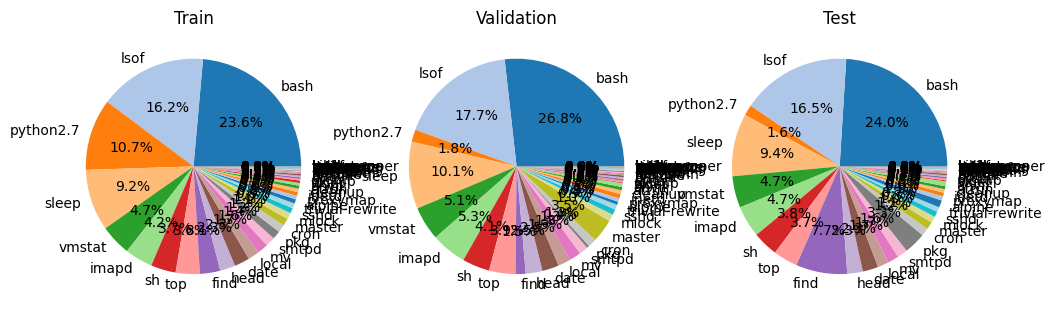

In [10]:
# print distributions in all 3 sets
train_distribution = Counter(y_train)
val_distribution = Counter(y_val)
test_distribution = Counter(y_test)

# plot 3 pie plots, use same colors for same classes
colors = plt.cm.tab20.colors
colors = [ colors[i % 20] for i in range(labels_cardinality) ]

# sort labels by occurence in training set
sorted_labels = sorted(train_distribution, key=train_distribution.get, reverse=True)

# sort all distributions by sorted_labels
train_distribution = [train_distribution[label] for label in sorted_labels]
val_distribution = [val_distribution[label] for label in sorted_labels]
test_distribution = [test_distribution[label] for label in sorted_labels]

# transform labels to names
sorted_labels = [labels_map[label] for label in sorted_labels]

fig, axs = plt.subplots(1, 3, figsize=(30*cm, 10*cm))
axs[0].pie(train_distribution, labels=sorted_labels, colors=colors, autopct='%1.1f%%')
axs[0].set_title('Train')
axs[1].pie(val_distribution, labels=sorted_labels, colors=colors, autopct='%1.1f%%')
axs[1].set_title('Validation')
axs[2].pie(test_distribution, labels=sorted_labels, colors=colors, autopct='%1.1f%%')
axs[2].set_title('Test')
plt.savefig(f'{checkpoint_path}/distributions.png')
plt.show()

In [11]:
# one-hot encode labels
y_train = np.eye(labels_cardinality)[y_train]
y_val = np.eye(labels_cardinality)[y_val]
y_test = np.eye(labels_cardinality)[y_test]

In [12]:
# one-hot encode features
# at this point, X_* are lists of tuples of vectorized features
def encode_features(sequence: np.ndarray) -> np.ndarray:
    # Precompute identity matrices
    event_eye = np.eye(event_types_cardinality)
    username_eye = np.eye(username_cardinality)

    # Initialize the output array with precomputed shapes
    encoded_seq = np.empty((len(sequence), event_eye.shape[1] + username_eye.shape[1]))

    for i, feature_vector in enumerate(sequence):
        event = event_eye[feature_vector[0]]
        username = username_eye[feature_vector[1]]

        # Concatenate all features into a single feature vector
        encoded_seq[i] = np.concatenate((event, username))

    return encoded_seq

X_train = [ encode_features(x) for x in X_train ]
X_val = [ encode_features(x) for x in X_val ]
X_test = [ encode_features(x) for x in X_test ]

In [13]:
feature_vector_cardinality = X_train[0].shape[1]

print(f'Feature vector cardinality: {feature_vector_cardinality}')

Feature vector cardinality: 45


In [14]:
X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)
X_test, y_test = shuffle(X_test, y_test)

build model

In [15]:
model = Sequential(layers=[
    Input(shape=(None, feature_vector_cardinality)),
    SimpleRNN(128, return_sequences=True),
    SimpleRNN(128, return_sequences=True),
    SimpleRNN(128, return_sequences=False),
    Dense(labels_cardinality, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 128)      │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 67)             │         8,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,707 (377.76 KB)

 Trainable params: 96,707 (377.76 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        verbose=1,
        mode='auto'
    ),
    ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1,
        mode='auto',
        min_lr=1e-7
    ),
    CSVLogger(
        filename=log_path,
        append=True
    )
]

loss = CategoricalCrossentropy()
optimizer = Adam(learning_rate=0.0001)

# class weights
y_train_int = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights_dict = dict(enumerate(class_weights))

metrics = [
    CategoricalAccuracy(name='categorical_accuracy'),
    TopKCategoricalAccuracy(k=top_k, name=f'top_{top_k}_categorical_accuracy'),
]

weighted_metrics = [
    CategoricalAccuracy(name='w_categorical_accuracy'),
    TopKCategoricalAccuracy(k=top_k, name=f'w_top_{top_k}_categorical_accuracy'),
]

# 'categorical_focal_crossentropy'
# 'categorical_crossentropy'
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics,
    weighted_metrics=weighted_metrics,
)

train model

In [ ]:
history = model.fit(
    x=Generator(X_train, y_train, 64, max_sequence_length),
    validation_data=Generator(X_val, y_val, 64, max_sequence_length),
    epochs=200,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# save history to file
with open(history_path, 'wb') as f:
    np.save(f, history.history)

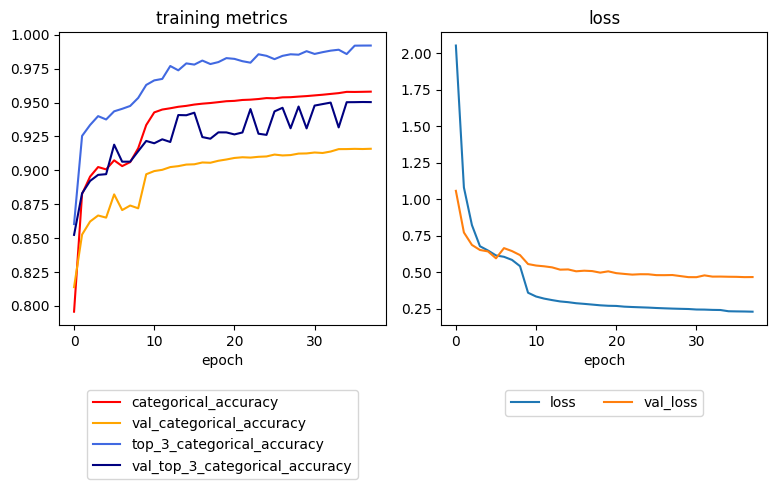

In [18]:
log = pd.read_csv(log_path)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20*cm, 15*cm))

ax1.plot(log['epoch'], log['categorical_accuracy'], label='categorical_accuracy', color='red')
ax1.plot(log['epoch'], log['val_categorical_accuracy'], label='val_categorical_accuracy', color='orange')
ax1.plot(log['epoch'], log[f'top_{top_k}_categorical_accuracy'], label=f'top_{top_k}_categorical_accuracy', color='royalblue')
ax1.plot(log['epoch'], log[f'val_top_{top_k}_categorical_accuracy'], label=f'val_top_{top_k}_categorical_accuracy', color='navy')
ax1.set_title('training metrics')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)  # Legend below the plot

ax2.plot(log['epoch'], log['loss'], label='loss')
ax2.plot(log['epoch'], log['val_loss'], label='val_loss')
ax2.set_title('loss')
ax2.set_xlabel('epoch')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)  # Legend below the plot

fig.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig(f'{checkpoint_path}/metrics_loss.svg')
plt.show()

In [19]:
# load old model, if needed
if model is None:
    model = load_model(model_path)

In [20]:
# evaluate model
score = model.evaluate(x=Generator(X_test, y_test, 128, max_sequence_length))
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')


  1/407 ━━━━━━━━━━━━━━━━━━━━ 3:23 500ms/step - categorical_accuracy: 0.8906 - loss: 0.3150 - top_3_categorical_accuracy: 0.9766 - w_categorical_accuracy: 0.8906 - w_top_3_categorical_accuracy: 0.9766


  4/407 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - categorical_accuracy: 0.9225 - loss: 0.2687 - top_3_categorical_accuracy: 0.9813 - w_categorical_accuracy: 0.9225 - w_top_3_categorical_accuracy: 0.9813   


  7/407 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - categorical_accuracy: 0.9311 - loss: 0.2540 - top_3_categorical_accuracy: 0.9827 - w_categorical_accuracy: 0.9311 - w_top_3_categorical_accuracy: 0.9827


 10/407 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - categorical_accuracy: 0.9323 - loss: 0.2514 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9323 - w_top_3_categorical_accuracy: 0.9829


 13/407 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - categorical_accuracy: 0.9336 - loss: 0.2514 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9336 - w_top_3_categorical_accuracy: 0.9828


 16/407 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - categorical_accuracy: 0.9343 - loss: 0.2520 - top_3_categorical_accuracy: 0.9827 - w_categorical_accuracy: 0.9343 - w_top_3_categorical_accuracy: 0.9827


 19/407 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - categorical_accuracy: 0.9352 - loss: 0.2523 - top_3_categorical_accuracy: 0.9826 - w_categorical_accuracy: 0.9352 - w_top_3_categorical_accuracy: 0.9826


 22/407 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - categorical_accuracy: 0.9361 - loss: 0.2502 - top_3_categorical_accuracy: 0.9826 - w_categorical_accuracy: 0.9361 - w_top_3_categorical_accuracy: 0.9826


 25/407 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - categorical_accuracy: 0.9368 - loss: 0.2489 - top_3_categorical_accuracy: 0.9826 - w_categorical_accuracy: 0.9368 - w_top_3_categorical_accuracy: 0.9826


 28/407 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - categorical_accuracy: 0.9373 - loss: 0.2474 - top_3_categorical_accuracy: 0.9827 - w_categorical_accuracy: 0.9373 - w_top_3_categorical_accuracy: 0.9827


 31/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.9377 - loss: 0.2468 - top_3_categorical_accuracy: 0.9826 - w_categorical_accuracy: 0.9377 - w_top_3_categorical_accuracy: 0.9826


 34/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.9380 - loss: 0.2461 - top_3_categorical_accuracy: 0.9826 - w_categorical_accuracy: 0.9380 - w_top_3_categorical_accuracy: 0.9826


 37/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.9382 - loss: 0.2452 - top_3_categorical_accuracy: 0.9826 - w_categorical_accuracy: 0.9382 - w_top_3_categorical_accuracy: 0.9826


 40/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.9385 - loss: 0.2439 - top_3_categorical_accuracy: 0.9827 - w_categorical_accuracy: 0.9385 - w_top_3_categorical_accuracy: 0.9827


 43/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.9387 - loss: 0.2424 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9387 - w_top_3_categorical_accuracy: 0.9828


 46/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.9389 - loss: 0.2416 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9389 - w_top_3_categorical_accuracy: 0.9828


 49/407 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - categorical_accuracy: 0.9391 - loss: 0.2409 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9391 - w_top_3_categorical_accuracy: 0.9828


 52/407 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - categorical_accuracy: 0.9393 - loss: 0.2404 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9393 - w_top_3_categorical_accuracy: 0.9828


 55/407 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - categorical_accuracy: 0.9394 - loss: 0.2399 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9394 - w_top_3_categorical_accuracy: 0.9828


 58/407 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - categorical_accuracy: 0.9396 - loss: 0.2393 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9396 - w_top_3_categorical_accuracy: 0.9828


 61/407 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - categorical_accuracy: 0.9397 - loss: 0.2388 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9397 - w_top_3_categorical_accuracy: 0.9828


 64/407 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - categorical_accuracy: 0.9399 - loss: 0.2384 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9399 - w_top_3_categorical_accuracy: 0.9828


 67/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.9400 - loss: 0.2379 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9400 - w_top_3_categorical_accuracy: 0.9829


 70/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.9401 - loss: 0.2376 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9401 - w_top_3_categorical_accuracy: 0.9829


 73/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.9402 - loss: 0.2374 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9402 - w_top_3_categorical_accuracy: 0.9829


 77/407 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.9404 - loss: 0.2370 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9404 - w_top_3_categorical_accuracy: 0.9829


 80/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9405 - loss: 0.2368 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9405 - w_top_3_categorical_accuracy: 0.9829


 83/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9406 - loss: 0.2366 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9406 - w_top_3_categorical_accuracy: 0.9829


 87/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9407 - loss: 0.2362 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9407 - w_top_3_categorical_accuracy: 0.9830


 90/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9408 - loss: 0.2360 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9408 - w_top_3_categorical_accuracy: 0.9830


 93/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9408 - loss: 0.2358 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9408 - w_top_3_categorical_accuracy: 0.9830


 96/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9409 - loss: 0.2356 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9409 - w_top_3_categorical_accuracy: 0.9830


 99/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9410 - loss: 0.2354 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9410 - w_top_3_categorical_accuracy: 0.9830


102/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9410 - loss: 0.2352 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9410 - w_top_3_categorical_accuracy: 0.9830


105/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9411 - loss: 0.2350 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9411 - w_top_3_categorical_accuracy: 0.9830


108/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9411 - loss: 0.2349 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9411 - w_top_3_categorical_accuracy: 0.9830


111/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9412 - loss: 0.2349 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9412 - w_top_3_categorical_accuracy: 0.9830


114/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9412 - loss: 0.2348 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9412 - w_top_3_categorical_accuracy: 0.9830


117/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9413 - loss: 0.2346 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9413 - w_top_3_categorical_accuracy: 0.9830


120/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9414 - loss: 0.2345 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9414 - w_top_3_categorical_accuracy: 0.9830


123/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9414 - loss: 0.2343 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9414 - w_top_3_categorical_accuracy: 0.9830


126/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9415 - loss: 0.2341 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9415 - w_top_3_categorical_accuracy: 0.9830


129/407 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - categorical_accuracy: 0.9415 - loss: 0.2339 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9415 - w_top_3_categorical_accuracy: 0.9830


132/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9416 - loss: 0.2337 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9416 - w_top_3_categorical_accuracy: 0.9830


135/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9417 - loss: 0.2336 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9417 - w_top_3_categorical_accuracy: 0.9830


138/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9417 - loss: 0.2334 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9417 - w_top_3_categorical_accuracy: 0.9830


141/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9418 - loss: 0.2333 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9418 - w_top_3_categorical_accuracy: 0.9830


144/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9418 - loss: 0.2331 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9418 - w_top_3_categorical_accuracy: 0.9830


148/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9419 - loss: 0.2330 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9419 - w_top_3_categorical_accuracy: 0.9830


151/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9419 - loss: 0.2328 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9419 - w_top_3_categorical_accuracy: 0.9830


154/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9420 - loss: 0.2327 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9420 - w_top_3_categorical_accuracy: 0.9830


157/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9420 - loss: 0.2327 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9420 - w_top_3_categorical_accuracy: 0.9830


160/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9421 - loss: 0.2326 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9421 - w_top_3_categorical_accuracy: 0.9830


163/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9421 - loss: 0.2326 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9421 - w_top_3_categorical_accuracy: 0.9830


167/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9421 - loss: 0.2325 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9421 - w_top_3_categorical_accuracy: 0.9830


170/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9421 - loss: 0.2325 - top_3_categorical_accuracy: 0.9830 - w_categorical_accuracy: 0.9421 - w_top_3_categorical_accuracy: 0.9830


173/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9422 - loss: 0.2325 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9422 - w_top_3_categorical_accuracy: 0.9829


176/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9422 - loss: 0.2325 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9422 - w_top_3_categorical_accuracy: 0.9829


179/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9422 - loss: 0.2324 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9422 - w_top_3_categorical_accuracy: 0.9829


182/407 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.9422 - loss: 0.2324 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9422 - w_top_3_categorical_accuracy: 0.9829


185/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9423 - loss: 0.2324 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9423 - w_top_3_categorical_accuracy: 0.9829


188/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9423 - loss: 0.2323 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9423 - w_top_3_categorical_accuracy: 0.9829


191/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9423 - loss: 0.2323 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9423 - w_top_3_categorical_accuracy: 0.9829


194/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9423 - loss: 0.2322 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9423 - w_top_3_categorical_accuracy: 0.9829


197/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9424 - loss: 0.2322 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9424 - w_top_3_categorical_accuracy: 0.9829


200/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9424 - loss: 0.2322 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9424 - w_top_3_categorical_accuracy: 0.9829


203/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9424 - loss: 0.2323 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9424 - w_top_3_categorical_accuracy: 0.9829


206/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9424 - loss: 0.2323 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9424 - w_top_3_categorical_accuracy: 0.9829


209/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9424 - loss: 0.2323 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9424 - w_top_3_categorical_accuracy: 0.9829


212/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9424 - loss: 0.2323 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9424 - w_top_3_categorical_accuracy: 0.9829


215/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9424 - loss: 0.2323 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9424 - w_top_3_categorical_accuracy: 0.9829


218/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9424 - loss: 0.2323 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9424 - w_top_3_categorical_accuracy: 0.9829


221/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9424 - loss: 0.2323 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9424 - w_top_3_categorical_accuracy: 0.9829


224/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9425 - loss: 0.2324 - top_3_categorical_accuracy: 0.9829 - w_categorical_accuracy: 0.9425 - w_top_3_categorical_accuracy: 0.9829


227/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9425 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9425 - w_top_3_categorical_accuracy: 0.9828


230/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9425 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9425 - w_top_3_categorical_accuracy: 0.9828


233/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9425 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9425 - w_top_3_categorical_accuracy: 0.9828


236/407 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.9425 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9425 - w_top_3_categorical_accuracy: 0.9828


239/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9425 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9425 - w_top_3_categorical_accuracy: 0.9828


242/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9425 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9425 - w_top_3_categorical_accuracy: 0.9828


245/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9425 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9425 - w_top_3_categorical_accuracy: 0.9828


248/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9426 - loss: 0.2325 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9426 - w_top_3_categorical_accuracy: 0.9828


251/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9426 - loss: 0.2325 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9426 - w_top_3_categorical_accuracy: 0.9828


254/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9426 - loss: 0.2325 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9426 - w_top_3_categorical_accuracy: 0.9828


257/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9426 - loss: 0.2325 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9426 - w_top_3_categorical_accuracy: 0.9828


260/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9426 - loss: 0.2325 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9426 - w_top_3_categorical_accuracy: 0.9828


263/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9426 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9426 - w_top_3_categorical_accuracy: 0.9828


266/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9426 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9426 - w_top_3_categorical_accuracy: 0.9828


269/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9427 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9427 - w_top_3_categorical_accuracy: 0.9828


272/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9427 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9427 - w_top_3_categorical_accuracy: 0.9828


275/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9427 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9427 - w_top_3_categorical_accuracy: 0.9828


278/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9427 - loss: 0.2324 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9427 - w_top_3_categorical_accuracy: 0.9828


281/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9427 - loss: 0.2323 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9427 - w_top_3_categorical_accuracy: 0.9828


284/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9427 - loss: 0.2323 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9427 - w_top_3_categorical_accuracy: 0.9828


287/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9427 - loss: 0.2323 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9427 - w_top_3_categorical_accuracy: 0.9828


290/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9427 - loss: 0.2323 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9427 - w_top_3_categorical_accuracy: 0.9828


293/407 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.9427 - loss: 0.2323 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9427 - w_top_3_categorical_accuracy: 0.9828


296/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9427 - loss: 0.2323 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9427 - w_top_3_categorical_accuracy: 0.9828


299/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9428 - loss: 0.2323 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9428 - w_top_3_categorical_accuracy: 0.9828


302/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9428 - loss: 0.2322 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9428 - w_top_3_categorical_accuracy: 0.9828


305/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9428 - loss: 0.2322 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9428 - w_top_3_categorical_accuracy: 0.9828


308/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9428 - loss: 0.2322 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9428 - w_top_3_categorical_accuracy: 0.9828


311/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9428 - loss: 0.2321 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9428 - w_top_3_categorical_accuracy: 0.9828


314/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9428 - loss: 0.2321 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9428 - w_top_3_categorical_accuracy: 0.9828


317/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9428 - loss: 0.2321 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9428 - w_top_3_categorical_accuracy: 0.9828


320/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9428 - loss: 0.2320 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9428 - w_top_3_categorical_accuracy: 0.9828


324/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9429 - loss: 0.2320 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9429 - w_top_3_categorical_accuracy: 0.9828


327/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9429 - loss: 0.2319 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9429 - w_top_3_categorical_accuracy: 0.9828


330/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9429 - loss: 0.2319 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9429 - w_top_3_categorical_accuracy: 0.9828


333/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9429 - loss: 0.2319 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9429 - w_top_3_categorical_accuracy: 0.9828


336/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9429 - loss: 0.2319 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9429 - w_top_3_categorical_accuracy: 0.9828


340/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9429 - loss: 0.2318 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9429 - w_top_3_categorical_accuracy: 0.9828


343/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9429 - loss: 0.2318 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9429 - w_top_3_categorical_accuracy: 0.9828


346/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9429 - loss: 0.2318 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9429 - w_top_3_categorical_accuracy: 0.9828


349/407 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.9430 - loss: 0.2318 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9430 - w_top_3_categorical_accuracy: 0.9828


353/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9430 - loss: 0.2317 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9430 - w_top_3_categorical_accuracy: 0.9828


356/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9430 - loss: 0.2317 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9430 - w_top_3_categorical_accuracy: 0.9828


360/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9430 - loss: 0.2317 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9430 - w_top_3_categorical_accuracy: 0.9828


364/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9430 - loss: 0.2316 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9430 - w_top_3_categorical_accuracy: 0.9828


367/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9430 - loss: 0.2316 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9430 - w_top_3_categorical_accuracy: 0.9828


370/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9430 - loss: 0.2316 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9430 - w_top_3_categorical_accuracy: 0.9828


374/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9430 - loss: 0.2315 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9430 - w_top_3_categorical_accuracy: 0.9828


378/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9430 - loss: 0.2315 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9430 - w_top_3_categorical_accuracy: 0.9828


381/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9431 - loss: 0.2315 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9431 - w_top_3_categorical_accuracy: 0.9828


384/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9431 - loss: 0.2315 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9431 - w_top_3_categorical_accuracy: 0.9828


388/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9431 - loss: 0.2315 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9431 - w_top_3_categorical_accuracy: 0.9828


391/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9431 - loss: 0.2314 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9431 - w_top_3_categorical_accuracy: 0.9828


395/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9431 - loss: 0.2314 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9431 - w_top_3_categorical_accuracy: 0.9828


398/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9431 - loss: 0.2314 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9431 - w_top_3_categorical_accuracy: 0.9828


401/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9431 - loss: 0.2314 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9431 - w_top_3_categorical_accuracy: 0.9828


404/407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9431 - loss: 0.2314 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9431 - w_top_3_categorical_accuracy: 0.9828


407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.9431 - loss: 0.2313 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9431 - w_top_3_categorical_accuracy: 0.9828


407/407 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - categorical_accuracy: 0.9431 - loss: 0.2313 - top_3_categorical_accuracy: 0.9828 - w_categorical_accuracy: 0.9431 - w_top_3_categorical_accuracy: 0.9828


Test loss: 0.22895465791225433
Test accuracy: 0.9439367055892944


In [21]:
# print classification report
y_pred = model.predict(x=Generator(X_test, y_test, 128, max_sequence_length))
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

distinct_labels = [labels_map[i] for i in range(labels_cardinality)]

report = classification_report(y_true, y_pred, target_names=distinct_labels, zero_division=np.nan)
report_dict = classification_report(y_true, y_pred, target_names=distinct_labels, zero_division=np.nan, output_dict=True)

print(report)

# save classification report to file
with open(f'{checkpoint_path}/classification_report.txt', 'w') as f:
    json.dump(report_dict, f)


  1/407 ━━━━━━━━━━━━━━━━━━━━ 4:13 624ms/step


  4/407 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step   


  8/407 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step


 12/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 16/407 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


 19/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 23/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 27/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 31/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 35/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 38/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 41/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 45/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 48/407 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


 52/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 56/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 60/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 64/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 68/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 72/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 76/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 79/407 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


 83/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


 87/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


 91/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


 95/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


 99/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


103/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


107/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


111/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


115/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


119/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


123/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


127/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


131/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


135/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


139/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


143/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


147/407 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


151/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


155/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


158/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


162/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


166/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


170/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


174/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


178/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


182/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


185/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


189/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


193/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


197/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


201/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


205/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


209/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


213/407 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


217/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


221/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


225/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


229/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


233/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


237/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


241/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


245/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


249/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


253/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


257/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


261/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


265/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


269/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


273/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


276/407 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


280/407 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


284/407 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


288/407 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


292/407 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


296/407 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


300/407 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


304/407 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


308/407 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


312/407 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


316/407 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


320/407 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


323/407 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


326/407 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


329/407 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


333/407 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


336/407 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


340/407 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


344/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


348/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


352/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


356/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


360/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


363/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


367/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


371/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


374/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


378/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


382/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


386/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


389/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


392/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


396/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


400/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


404/407 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


407/407 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step


                 precision    recall  f1-score   support

      adjkerntz       0.44      1.00      0.61        11
         alpine       0.83      0.98      0.90       560
          anvil       0.32      0.90      0.47       378
          atrun       0.99      1.00      1.00       237
            awk       0.83      1.00      0.91         5
       basename        nan      0.00      0.00         2
           bash       1.00      0.99      0.99     12512
            cat       0.92      0.92      0.92        26
        cleanup       0.48      0.71      0.57       276
            cmp       1.00      1.00      1.00         5
             cp       1.00      1.00      1.00        30
           cron       1.00      1.00      1.00       624
           date       1.00      1.00      1.00      1218
             dd       1.00      0.99      1.00       125
       dhclient       0.00      0.00      0.00        17
          dmesg       0.88      1.00      0.94        15
          egrep       1.00    

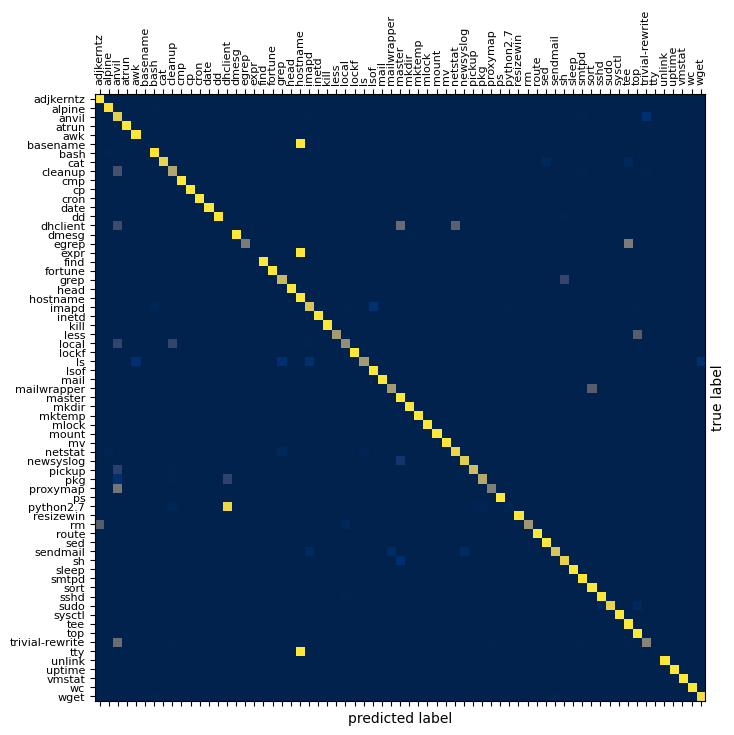

In [22]:
# print confusion matrix
# labels explicitly set, because current model may not predict all labels
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(labels_cardinality), normalize='true')

# Replace all NaN values with 0
conf_matrix = np.nan_to_num(conf_matrix)

# Verify the distinct labels align correctly
distinct_labels = [labels_map[i] for i in range(labels_cardinality)]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(20*cm, 20*cm))

ax.matshow(conf_matrix, cmap='cividis', aspect='auto')

# Set class names on axes
ax.set_xticks(range(len(distinct_labels)))
ax.set_yticks(range(len(distinct_labels)))
ax.set_xticklabels(distinct_labels, rotation=90, fontsize=8)
ax.set_yticklabels(distinct_labels, fontsize=8)

# Set axis labels "predicted" and "actual"
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')
# y-axis label right side
ax.yaxis.set_label_position('right')

# set figsize
plt.savefig(f'{checkpoint_path}/confusion_matrix.svg')
plt.show()

In [23]:
unique_in_y_pred = [ labels_map[i] for i in np.unique(y_pred) ]
#print("Unique labels in y_pred:", unique_in_y_pred)

unique_not_in_y_pred = [ label for label in distinct_labels if label not in unique_in_y_pred ]
print("Unique labels not in y_pred:", unique_not_in_y_pred)

Unique labels not in y_pred: ['basename', 'expr', 'tty']
